# 1a

Note that I have used $\sigma$ to represent the density of trees pr. unit area instead of $n$. I didn't notice it before I had already written most of the code, so I haven't bothered to change it.  

Using $n$ for density just feels weird :)

## 1.

In [21]:
import numpy as np
import matplotlib.pyplot as plt


These are some helper functions that will be used at various points throughout the assignment.

In [22]:
def generateRandomPoint(width, height):
    '''Helper function to (uniformly) generate a random point within a square of a given width and height.'''
    return (np.random.uniform(0, width), np.random.uniform(0, height))

def generateRandomPointInCircle(R):
    '''Generate a random point within a circle of radius R centered at the origin.'''
    theta = np.random.uniform(0, 2 * np.pi)
    r = R * np.sqrt(np.random.uniform(0, 1))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def distance(x1, y1, x2, y2):
        '''Gets the distance between (x1, y1) and (x2, y2).'''
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def distToLine(a, b, x0, y0):
    '''Calculates the distance from (x0, y0) to the line y = a x + b'''
    return np.abs(a*x0 + b - y0)/np.sqrt(1 + a**2)

def line_circleIntersection(a, b, x_C, y_C, R):
    '''Takes in the parameters defining a line and a circle and finds the point of intersection closest to the origin. Assumes there is a point of intersection! Also assumes the line passes through the origin.
    
    Returns the point of intersection as a tuple (x,y)
    '''
    # Define coefficients
    A = a**2 + 1
    B = 2*a*b -2*a*y_C -2*x_C
    C = -R**2 +b**2 -2*b*y_C +x_C**2 +y_C**2
    # Calculate points of intersection
    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        raise ValueError("No intersection between the line and the circle.")
    x1 = (-B + np.sqrt(discriminant)) / (2*A)
    y1 = a*x1 + b
    x2 = (-B - np.sqrt(discriminant)) / (2*A)
    y2 = a*x2 + b
    # Find the one closest to the origin and return it
    if distance(x1, y1, 0, 0) < distance(x2, y2, 0, 0):
        return (x1, y1)
    else:
        return (x2, y2)

def mergeForests(forest1, forest2):
    '''Takes two forests and returns a single forest containing all their trees.'''
    res = []

    for tree in forest1:
        res.append(tree)
    for tree in forest2:
        res.append(tree)
        
    return res

def chiSquared(Y_obs, Y_model, Y_err):
    '''Calculates the chi-squared statistic for the given data and model.'''
    res = 0
    for i in range(len(Y_obs)):
        res += (Y_obs[i] - Y_model[i])**2 / Y_err[i]**2
    return res



We'll represent the trees with a class, containing information about their position, diameter, color, etc.

In [23]:
class Tree:
    def setOriginDistance(self, d):
        '''
        Sets the distance of self to the origin to d
        
        NB: This doesn't change the position of the Tree!
        '''
        self.origin_dist = d

    def setDiameter(self, D):
        '''Sets diameter of self to D.'''
        self.diameter = D
        
    def setPosition(self, x, y):
        '''Sets position of self to (x,y).'''
        self.x_pos = x
        self.y_pos = y

    def setArgument(self, theta):
        '''This sets the angle between self and the x-axis to theta. Equivalent to the argument of a complex number.'''
        self.arg = theta

    def setColor(self, color):
        '''Sets the color of the tree to color.'''
        self.color = color

    def __lt__(self, other):
        '''For sorting purposes. Returns True if self is closer to the origin than other, False otherwise.'''
        return self.origin_dist < other.origin_dist


            

If the forest is big enough, it is impossible to tell whether you are at the center or not just by looking around. This means we can assume that Robin Hood is at the center, so we simply place him at the origin and generate a circular forest around him, making sure not to place trees at the origin.  

In fact, for the sake of realism, let's give Robin some space and say that he is at least one meter from any trees.

In a large forest, it is practically impossible to tell whether you're in the center or not, so we'll assume Robin Hood is at the center of the forest. This allows us to consider a spherical forest, with Robin Hood at the origin.  

But we can't just generate a forest with a predetermined size, since we don't know how far the arrow will need to travel before it hits a tree. Instead, let's proceed by generating a ring of forest with a certain thickness at some distance from the origin. 

We can then start by generating a ring at distance 0, i.e. a circle around the origin, and add more rings of forest as required until the arrow hits something. Of course, we will need to pass our old forest as an argument to the function, since we need to avoid placing new trees on top of existing ones.

In [24]:
# We use the values from Ryden's book and R=0, dR=100 as our default values
def generateForest(sigma=0.005, D=2, R=0, dR=10, old_forest=[]):
    '''
    Generates a 2d forest of trees placed randomly (uniformly) in a ring centered on the origin. If used with an existing forest, returns both the old forest and the new trees placed.

    Parameters:
    sigma: The density of the trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the ring will begin
    dR: The thickness of the ring
    old_forest: An existing forest to append the new one to
    
    Returns a nested list of Tree objects, containing the trees in the old forest and the trees in the new ring.
    '''
    # Calculate area and number of trees to place
    area = np.pi*((R + dR)**2 - R**2)
    n_trees = int(sigma*area)

    added_forest_ring = []

    while len(added_forest_ring) < n_trees:
        new_tree = Tree()

        # Get random position for the new tree
        theta = np.random.uniform(0, 2*np.pi)
        r = np.random.uniform(R, R + dR)
        x = r*np.cos(theta)
        y = r*np.sin(theta)

        origin_dist = distance(x, y, 0, 0)

        # Check if the new tree touches any trees in the old forest or any of the newly generated trees
        # We also make sure not to place any trees at the origin
        if all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in old_forest) and all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in added_forest_ring) and origin_dist > D: # all() returns True iff all elements of a list are True
            new_tree.setDiameter(D)
            new_tree.setPosition(x, y)
            new_tree.setOriginDistance(origin_dist)
            new_tree.setArgument(theta)
            new_tree.setColor('green')

            added_forest_ring.append(new_tree)

    return [old_forest, added_forest_ring]
        



I've decided to have the function return the old and new forest seperately for the sake of efficiency. This way we will be able to check only the newly generated trees instead of looping over all of the ones that are behind the arrow.  

It would be nice to have a plot of the forest, so let's add a function for that. We'll also add the option to plot the trajectory of the arrow.

In [25]:
def plotForest(forest, theta=None, arrow_distance=None):
    '''
    Plots a forest of Trees. If given an angle theta and a distance arrow_distance, it will also plot an arrow from the origin to the point (arrow_distance, theta).
    '''
    # Used to avoid setting a label for each Tree
    label_has_been_set = False

    R = 0

    # This adds each tree to the forest
    for tree in forest:
        if label_has_been_set:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color=tree.color, fill=True)
        else:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color=tree.color, fill=True, label='Tree')
            label_has_been_set = True
        # Keep track of the radius of the forest
        current_dist = distance(tree.x_pos, tree.y_pos, 0, 0)
        if current_dist > R:
            R = current_dist

        plt.gca().add_artist(circle)

    # Draws boundary around the forest    
    circle = plt.Circle((0, 0), R, color='black', fill=False, linestyle='dashed', label='Forest Boundary')
    plt.gca().add_artist(circle)

    # Draws a dot at the origin
    plt.plot(0, 0, 'ro', label='Robin Hood')

    # Makes sure the axes are scaled the same, so the plot doesn't become 'squished'
    plt.axis('equal')
    # Sets appropriate x and y limits to make the whole forest visible
    plt.xlim(-1.5*R, 1.5*R)
    plt.ylim(-1.5*R, 1.5*R)

    # If given an angle and a distance, plot an arrow from the origin to the point (arrow_distance, theta)
    if theta is not None and arrow_distance is not None:
        x_arrow = arrow_distance*np.cos(theta)
        y_arrow = arrow_distance*np.sin(theta)
        plt.arrow(0, 0, x_arrow, y_arrow, fc='blue', ec='blue', label='Arrow Trajectory')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sherwood Forest')
    plt.legend(loc='upper right')
    plt.show()


Time to test it.

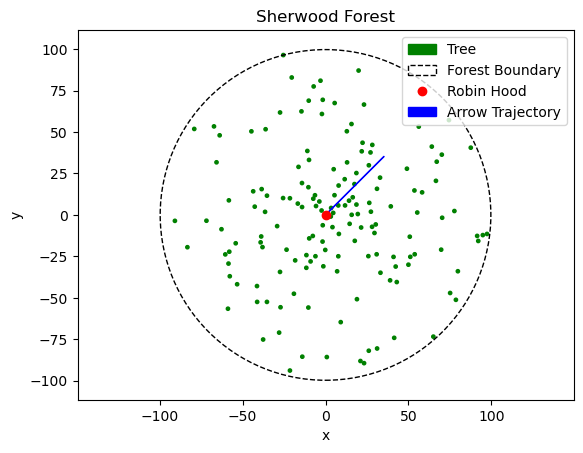

In [26]:
forest = generateForest(dR=100)[1]
plotForest(forest, np.pi/4, 50)

Looks great!

## 2.

Now we need to implement the shooting of the arrow and find the length it travels before hitting a tree. Since Robin Hood is shooting the arrow from the origin, we can represent its path with a line $l$ given by $y = a x + b$. We can use the formula for the distance from a point to a line to get the distance from the center of a tree at $C=(x_C, y_C)$ to $l$:  

$\text{dist}(C, l) = \dfrac{|a x_C + b - y_C|}{\sqrt{a^2 + 1}}$  

Obviously, if this distance is less than the radius of the tree, the arrow will hit it. 

If we do hit a tree, we also need to find the point of intersection. Combining the equation of the circle representing the tree with the equation for $l$ at the point of intersection $(x_0, y_0)$ yields:

$(x_0 - x_C)^2 + (a x_0 + b - y_C)^2 = R^2$

Which is a quadratic equation $A x_0^2 + B x_0 + C = 0$ with the following coefficients:  

$A = a^2 + 1$  
$B = 2 a b - 2 a y_C -2 x_C$  
$C = -R^2 +b^2 -2 b y_C + x_C^2 +y_C^2$

So the points of intersection are:

$\left(\dfrac{-B \pm \sqrt{B^2 - 4 A C}}{2 A}, a\left[\dfrac{-B \pm \sqrt{B^2 - 4 A C}}{2 A}\right] + b \right)$

We can simply calculate both possible points of intersection and return the one closest to the origin.

As the arrow can only travel in one direction along the line, we'll need to make sure we only check one ''side'' of the line. Otherwise we might detect collisions with the part of the line that is opposite the arrow's direction of travel. This can be done by comparing the angle the path of the arrow makes with the origin and the argument of the trees.  

Finally, we need to ensure that we check the trees closest to the origin first. It wouldn't do to abort the loop because we found a collision with some faraway tree, possibly ignoring a collision closer to the origin. Fortunately, our tree objects are sortable by their distance to the origin.

In [27]:
def shootArrow(theta=0, sigma=0.005, D=2, R=0, dR=10):
    '''
    Shoots an arrow at an angle theta with the positive x-axis and determines how far it travels.

    Parameters:
    theta: The angle with the positive x-axis at which the arrow was fired
    sigma: The density of the trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the first ring will begin
    dR: The thickness of the rings

    Returns a tuple containing the distance to the point of intersection at index 0 and the forest associated with the arrow at index 1.
    '''
    
    # Slope of the line
    a = np.tan(theta)
    b = 0 # Since we're shooting from the origin

    old_forest = []

    while True:
        # Generate some new forest for the arrow
        old_forest, added_forest_ring = generateForest(sigma, D, R, dR, old_forest)
        current_forest = mergeForests(old_forest, added_forest_ring)
        # We sort the trees from closest to furthest from the origin
        added_forest_ring.sort()

        old_forest = current_forest

        # Only check the newly generated trees
        for tree in added_forest_ring:
            # Check if the tree is in the direction in which the arrow is traveling
            if (theta - np.pi/2) <= tree.arg <= (theta + np.pi/2):
                # If the line intersects the tree, return the distance the arrow flew
                if distToLine(a, b, tree.x_pos, tree.y_pos) <= tree.diameter / 2:
                    intersection = line_circleIntersection(a, b, tree.x_pos, tree.y_pos, tree.diameter / 2)
                    tree.color = 'red' # Makes it easier to see which tree was hit
                    return (distance(intersection[0], intersection[1], 0, 0), current_forest)
        
        # If we haven't hit anything after trying all of the trees, we generate another ring of the forest at the edge of the current one and try again
        R += dR

    

Let's see if it works.

The arrow traveled approximately 270 units before hitting a tree.


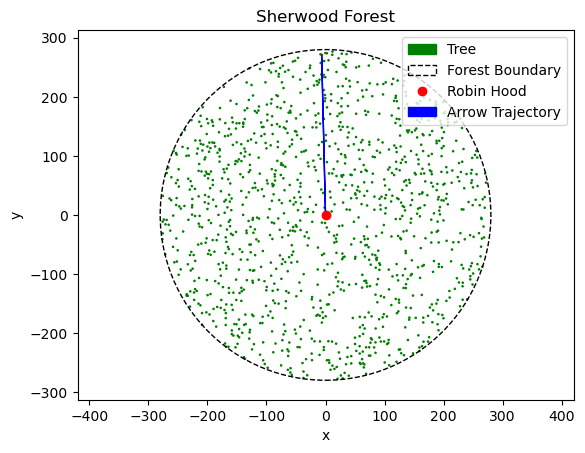

In [28]:
# Generate a random angle to shoot the arrow at
theta = np.random.uniform(0, 2*np.pi)
dist, forest = shootArrow(theta, sigma=0.005, dR=10)
print(f"The arrow traveled approximately {round(dist)} units before hitting a tree.")
plotForest(forest, theta, dist)

It does! Awesome.

## 3.1

Before we start shooting tons of arrows and doing statistics, let's try to predict what $L$ will be.

Consider the tree density, $\sigma$:  

$\sigma = \dfrac{N}{A}$

where $N$ is the number of trees in some area $A$. If we want to find out how big of an area we would need for there to be one tree on average, we just need to set $N = 1$, which gives:

$A = \dfrac{1}{\sigma}$

The way we have modelled collisions between the arrow and the trees, we are essentially imagining the arrow having a 2d equivalent ''cross-sectional area'', $D$. It sweeps out a rectangle as it moves forward, and if any tree centers are located within that rectangle, we detect a collision. The area swept out by the arrow when it has moved a distance l is:

$A_l = l D$

To find $L$ we proceed similarly to how one would find the mean free path of a particle in 3d space and ask ourselves: How far will the arrow have to travel to sweep out the area where we would expect to find one tree?  

$A_L = L D = \dfrac{1}{\sigma}$

$\implies L = \dfrac{1}{\sigma D}$

Let's see if this prediction is correct!

## 3.2

In [29]:
def repeatedArrowShooting(sigma=0.005, D=2, R=0, dR=10, n_arrows=5):
    '''
    Shoots n_arrows arrows at random angles and determines how far each arrow travels before hitting a tree.

    Parameters:
    sigma: The density of the trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the first ring will begin
    dR: The thickness of the rings
    n_arrows: The number of arrows to shoot

    Returns a list of tuples containing the forest, angle and distance for each arrow.
    '''
    
    results = []

    for i in range(n_arrows):
        theta = np.random.uniform(0, 2*np.pi)
        dist, forest = shootArrow(theta, sigma, D, R, dR)
        results.append((forest, theta, dist))
    
    return results


In [30]:
def arrowStats(results):
    '''
    Calculates the avergae distance an arrow travels before hitting a tree.
    
    Takes in a list of results from repeatedArrowShooting() and returns the average distance and the associated error on the mean.
    '''
    distances = [result[2] for result in results]
    mean = np.mean(distances)
    error = np.std(distances)/np.sqrt(len(distances))
    return (mean, error)


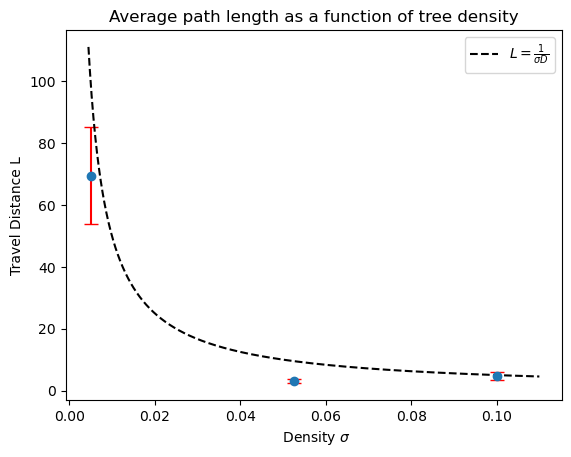

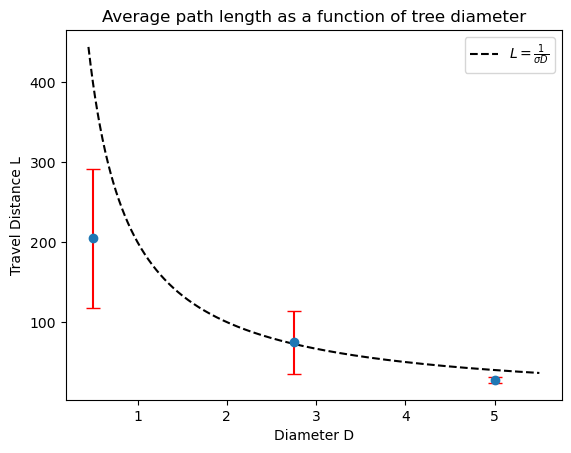

In [31]:
n_points = 3

dR = 10
n_arrows = 3

min_sigma, max_sigma = 0.005, 0.1
sigma_vals = np.linspace(min_sigma, max_sigma, n_points)

min_D, max_D = 0.5, 5
D_vals = np.linspace(min_D, max_D, n_points)


# This is kinda ugly, but I don't really care
sigma_res = []
for sigma in sigma_vals:
    sigma_res.append(repeatedArrowShooting(sigma=sigma, dR=dR, n_arrows=n_arrows))

for i in range(len(sigma_res)):
    sigma_res[i] = arrowStats(sigma_res[i])

D_res = []
for D in D_vals:
    D_res.append(repeatedArrowShooting(D=D, dR=dR, n_arrows=n_arrows))

for i in range(len(D_res)):
    D_res[i] = arrowStats(D_res[i])

def L_func(sigma, D):
    return 1/(sigma*D)

X_sigma = np.linspace(min_sigma*0.9, max_sigma*1.1, 1000)
X_D = np.linspace(min_D*0.9, max_D*1.1, 1000)


# Plot the results
plt.figure()
plt.errorbar(sigma_vals, [res[0] for res in sigma_res], yerr=[res[1] for res in sigma_res], ecolor='red', capsize=5, fmt='o')
plt.xlabel(r' Density $\sigma$')
plt.ylabel('Travel Distance L')
plt.title('Average path length as a function of tree density')

# Plot our prediction
plt.plot(X_sigma, L_func(X_sigma, 2), linestyle="dashed", color="black", label=r'$L = \frac{1}{\sigma D}$')

plt.legend()
plt.show()


plt.figure()
plt.errorbar(D_vals, [res[0] for res in D_res], yerr=[res[1] for res in D_res], ecolor='red', capsize=5, fmt='o')
plt.xlabel('Diameter D')
plt.ylabel('Travel Distance L')
plt.title('Average path length as a function of tree diameter')

# Plot our prediction
plt.plot(X_D, L_func(0.005, X_D), linestyle="dashed", color='black', label=r'$L = \frac{1}{\sigma D}$')

plt.legend()
plt.show()



Well, that looks promising enough. But this code usually takes a long time, even for only 3 points with 3 arrows per point (and I'm using a beefy gaming PC!) 

The errors are so high I won't even bother calculating the $\chi^2$-value. We'll need to optimize our code if we want to shoot enough arrows in our lifetimes to get good statistics.

In a sense, shooting an arrow in a random direction in a randomized forest is a bit redundant. Shooting an arrow in a fixed direction and changing the forest would have the same effect.  

If we choose to always shoot the arrow in the positive x direction for instance, we can limit our forest generation to only generate trees along that direction.

In [39]:
def generateForestOptimized(sigma=0.005, D=2, X=0, dX=50, old_forest=[]):
    '''
    This generates a patch of forest in a rectangle along the trajectory of the arrow. Assumes the arrow is shot along the positive x-axis. Assumes theta = 0!

    Parameters:
    sigma: The density of the trees pr. unit area
    D: The diameter of the trees in the forest
    X: The distance from the origin at which the rectangle will begin
    dX: The width of the rectangle
    old_forest: An existing forest

    Returns a nested list of Tree objects, containing the trees in the old forest and the trees in the new rectangle.
    '''
    # The width of our rectangle
    width = 6*D

    # Calculate area and number of trees to place
    area = dX*width
    n_trees = int(sigma*area)

    added_forest_rect = []

    while len(added_forest_rect) < n_trees:
        new_tree = Tree()

        # Get random position for new tree
        x = np.random.uniform(X, X + dX)
        y = np.random.uniform(-width/2, width/2)

        origin_dist = distance(x, y, 0, 0)

        # Check if the new tree touches any trees in the old forest or any of the newly generated trees
        # We also make sure not to place any trees at the origin
        if all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in old_forest) and all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in added_forest_rect) and origin_dist > D: # all() returns True iff all elements of a list are True
            new_tree.setDiameter(D)
            new_tree.setPosition(x, y)
            new_tree.setOriginDistance(origin_dist)
            new_tree.setArgument(theta)
            new_tree.setColor('green')

            added_forest_rect.append(new_tree)
            
    return [old_forest, added_forest_rect]


In [41]:
def shootArrowOptimized(theta=0, sigma=0.005, D=2, X=0, dX=50):
    '''
    Identical to shootArrow(), but uses optimized forest generation.

    Shoots an arrow at an angle theta with the positive x-axis and determines how far it travels.

    Parameters:
    theta: The angle with the positive x-axis at which the arrow was fired
    sigma: The density of the trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the first ring will begin
    dR: The thickness of the rings

    Returns a tuple containing the distance to the point of intersection at index 0 and the forest associated with the arrow at index 1.
    '''
    
    # Slope of the line
    a = np.tan(theta)
    b = 0 # Since we're shooting from the origin

    old_forest = []

    while True:
        # Generate some new forest for the arrow
        old_forest, added_forest_rect = generateForestOptimized(sigma, D, X, dX, old_forest)
        current_forest = mergeForests(old_forest, added_forest_rect)
        # We sort the trees from closest to furthest from the origin
        added_forest_rect.sort()

        old_forest = current_forest

        # Only check the newly generated trees
        for tree in added_forest_rect:
            # If the line intersects the tree, return the distance the arrow flew
            if distToLine(a, b, tree.x_pos, tree.y_pos) <= tree.diameter / 2:
                intersection = line_circleIntersection(a, b, tree.x_pos, tree.y_pos, tree.diameter / 2)
                tree.color = 'red' # Makes it easier to see which tree was hit
                return (distance(intersection[0], intersection[1], 0, 0), current_forest)
        
        # If we haven't hit anything after trying all of the trees, we generate another ring of the forest at the edge of the current one and try again
        X += dX

    

In [42]:
def repeatedArrowShootingOptimized(sigma=0.005, D=2, X=0, dX=50, n_arrows=5):
    '''
    Shoots n_arrows arrows at random angles and determines how far each arrow travels before hitting a tree.

    Parameters:
    sigma: The density of the trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the first ring will begin
    dR: The thickness of the rings
    n_arrows: The number of arrows to shoot

    Returns a list of tuples containing the forest, angle and distance for each arrow.
    '''
    
    results = []

    for i in range(n_arrows):
        dist, forest = shootArrowOptimized(0, sigma, D, X, dX)
        results.append((forest, theta, dist))
    
    return results


I've updated shootArrow() and repeatedArrowShooting() to use our new generating function. Fingers crossed!

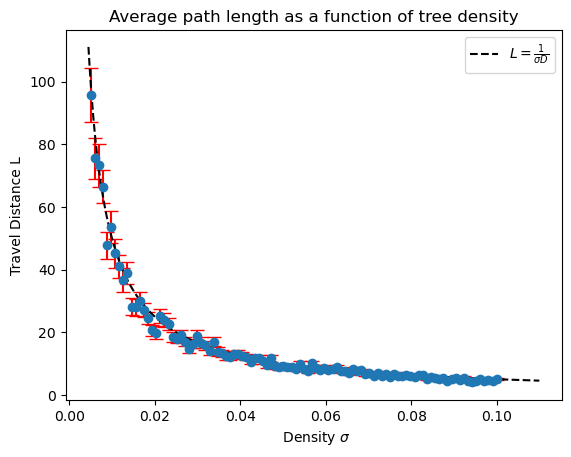

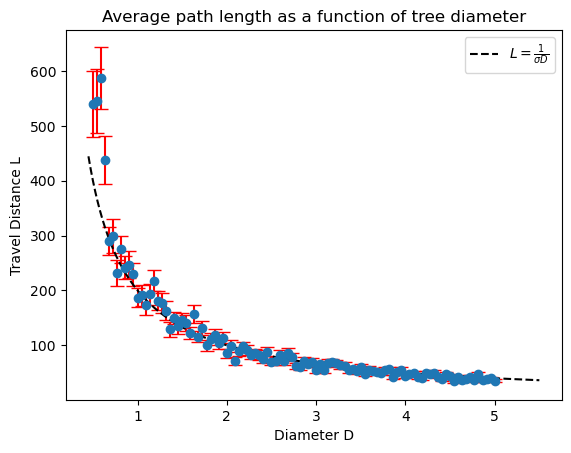

Chi-squared value for sigma: 187.14
Chi-squared value for D: 175.45


In [ ]:
n_points = 10

dX = 100
n_arrows = 10000

min_sigma, max_sigma = 0.005, 0.1
sigma_vals = np.linspace(min_sigma, max_sigma, n_points)

min_D, max_D = 0.5, 5
D_vals = np.linspace(min_D, max_D, n_points)

# This is kinda ugly, but I don't really care
sigma_res = []
for sigma in sigma_vals:
    sigma_res.append(repeatedArrowShootingOptimized(sigma=sigma, dX=dX, n_arrows=n_arrows))

for i in range(len(sigma_res)):
    sigma_res[i] = arrowStats(sigma_res[i])

D_res = []
for D in D_vals:
    D_res.append(repeatedArrowShootingOptimized(D=D, dX=dX, n_arrows=n_arrows))

for i in range(len(D_res)):
    D_res[i] = arrowStats(D_res[i])

def L_func(sigma, D):
    return 1/(sigma*D)

X_sigma = np.linspace(min_sigma*0.9, max_sigma*1.1, 1000)
X_D = np.linspace(min_D*0.9, max_D*1.1, 1000)


# Plot the results
plt.figure()
plt.errorbar(sigma_vals, [res[0] for res in sigma_res], yerr=[res[1] for res in sigma_res], ecolor='red', capsize=5, fmt='o')
plt.xlabel(r' Density $\sigma$')
plt.ylabel('Travel Distance L')
plt.title('Average path length as a function of tree density')

# Plot our prediction
plt.plot(X_sigma, L_func(X_sigma, 2), linestyle="dashed", color="black", label=r'$L = \frac{1}{\sigma D}$')

plt.legend()
plt.show()


plt.figure()
plt.errorbar(D_vals, [res[0] for res in D_res], yerr=[res[1] for res in D_res], ecolor='red', capsize=5, fmt='o')
plt.xlabel('Diameter D')
plt.ylabel('Travel Distance L')
plt.title('Average path length as a function of tree diameter')

# Plot our prediction
plt.plot(X_D, L_func(0.005, X_D), linestyle="dashed", color='black', label=r'$L = \frac{1}{\sigma D}$')

plt.legend()
plt.show()

# Calculate chi-squared values
chi_squared_sigma = chiSquared([res[0] for res in sigma_res], L_func(sigma_vals, 2), [res[1] for res in sigma_res])
chi_squared_D = chiSquared([res[0] for res in D_res], L_func(0.005, D_vals), [res[1] for res in D_res])

print(f"Chi-squared value for sigma: {round(chi_squared_sigma, 2)}")
print(f"Chi-squared value for D: {round(chi_squared_D, 2)}")




Et voilà! 